Based on Chris McCormick and Nick Ryan's Bert Fine-Tuning Tutorial with PyTorch

In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 12.1MB/s 
     |████████████████████████████████| 1.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 3.8MB 46.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7ecd2cc8a51172b6bf6b3c76b619e2b8146c77ade593f86f11e3be7657fa3040
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from google.colab import files
uploaded = files.upload()

Saving bill-texts-labeled.csv to bill-texts-labeled.csv


In [0]:
import io
import pandas as pd

df2 = pd.read_csv(io.BytesIO(uploaded['bill-texts-labeled.csv']))
df2

""


In [0]:
import torch
import numpy as np
import os 
import pandas
import random
from transformers import BertConfig
import time


Using the GPU

To add a GPU in Colab: Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

In [0]:
use_cuda = True # set to True if you want to use GPU
if use_cuda:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # if we want to use alt cuda device
        # device = torch.device(f"cuda:{cuda_device}")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        # print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        print("No gpu available")
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

There are 1 GPU(s) available.


In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# optional adding a custom configuration
config_class = BertConfig


In [0]:
import re
import string

bill_exs = df2.iloc[ : , 0]
labels = df2.iloc[:, 1]

train_exs = bill_exs[:int((len(bill_exs) * 4/5.0))]
test_exs = bill_exs[int((len(bill_exs) * 4/5.0)):]

train_labels = labels[:int((len(labels) * 4/5.0))]
test_labels = labels[int((len(labels) * 4/5.0)):]
# not even going to bother looking for max bec this is the bert max len and we definitely exceed it for almost all (bec documents not sentences)
max_len = 512

exs = []
for ex in train_exs:
  tokenized_cleaned_sent = []
  # todo still not getting rid of all 's: need to fix this
  tokens = re.split('[- /\\n]', ex)
  for word in tokens:
      word_clean = word.strip(string.punctuation).lower()
      if word_clean != '' and word_clean != '\r':
          tokenized_cleaned_sent.append(word_clean)
  exs.append(' '.join(tokenized_cleaned_sent))
print(exs[0])

 at least three developmental skills including literacy or test at least two developmental skills other than literacy and be administered in conjunction with a separate reading instrument that is on a list adopted under this subsection a multidimensional assessment tool administered as provided by this subsection is considered to be a reading instrument for purposes of this section a district level committee established under subchapter f chapter 11 may adopt a list of reading instruments for use in the district in a grade level other than kindergarten in addition to the reading instruments on the commissioner's list each reading instrument adopted by the commissioner or a district level committee must be based on scientific research concerning reading skills development and reading comprehension a list of reading instruments adopted under this subsection must provide for diagnosing the reading development and comprehension of students participating in a program under subchapter b chap

In [0]:
input_ids = []
attention_masks = []

# For every sentence...
for ex in exs:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        ex,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

print(input_ids[0])

tensor([  101,  6564,  2099, 10790, 21619,  2692,  2033,  2860,  1047,  6460,
         1039,  3501,  2278, 24529,  2099,  1042,  2011, 15346,  2100,  1044,
         1012,  1038,  2053,  1017,  1037,  3021,  2000,  2022,  4709,  2019,
         2552,  8800,  2000,  2270,  2082,  5446,  1998,  2270,  2495,  2022,
         2009, 11955,  2011,  1996,  6372,  1997,  1996,  2110,  1997,  3146,
         3720,  1015,  2270,  2082,  5446,  2930,  1015,  1012, 25604,  2930,
         2260,  1012, 10114,  2495,  3642,  2003, 13266,  2011, 27950,  2075,
         4942, 29015,  2015,  1037,  1998,  1037,  1015,  1998,  5815,  4942,
        29015,  1037,  1017,  2000,  3191,  2004,  4076,  1037,  1037,  6111,
         9111,  2003,  4709,  2000,  4374,  2005,  1996,  2330, 10316,  6111,
         2082,  4804,  2104,  3127,  4466,  4413,  5020,  2000,  1996,  3815,
         1997,  4804,  2566,  3076,  1999, 18215,  2779,  3679,  5270, 13343,
         1996,  2035,  4140,  3672,  2104,  2930,  4466,  1012, 

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.90 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,428 training samples
  381 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
# building the model
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels = 30, 
                                                      output_attentions = False,
                                                      output_hidden_states = False)

# Alternatively: if you have a BertConfig set up
# model = BertForSequenceClassification.from_pretrained("bert-base-cased", config)

# optional - having a list of weights for each label for loss calculation.
# would add this param to next line -  weight=torch.Tensor(self.weight).to(self.device))

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    model.train()

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0


    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        total_train_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    429.    Elapsed: 0:00:31.
  Batch    80  of    429.    Elapsed: 0:01:02.
  Batch   120  of    429.    Elapsed: 0:01:34.
  Batch   160  of    429.    Elapsed: 0:02:07.
  Batch   200  of    429.    Elapsed: 0:02:39.
  Batch   240  of    429.    Elapsed: 0:03:11.
  Batch   280  of    429.    Elapsed: 0:03:43.
  Batch   320  of    429.    Elapsed: 0:04:16.
  Batch   360  of    429.    Elapsed: 0:04:48.
  Batch   400  of    429.    Elapsed: 0:05:21.

  Average training loss: 2.01
  Training epcoh took: 0:05:44

Running Validation...
  Accuracy: 0.68
  Validation Loss: 1.27
  Validation took: 0:00:13

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    429.    Elapsed: 0:00:32.
  Batch    80  of    429.    Elapsed: 0:01:05.
  Batch   120  of    429.    Elapsed: 0:01:37.
  Batch   160  of    429.    Elapsed: 0:02:10.
  Batch   200  of    429.    Elapsed: 0:02:42.
  Batch   240  of    429.    Elapsed: 0:03:14.
  Batch   280  of    429.    Elapsed: 0:03:47.
  Bat

In [0]:
# have to check testing accuracy
exs_t = []
for ex in test_exs:
  tokenized_cleaned_sent = []
  # todo still not getting rid of all 's: need to fix this
  tokens = re.split('[- /\\n]', ex)
  for word in tokens:
      word = word.strip(string.punctuation).lower()
      word_clean = re.sub('\'s', '', word)
      if word_clean != '' and not any(i.isdigit() for i in word_clean) and word_clean != '\r':
          tokenized_cleaned_sent.append(word_clean)
  exs_t.append(' '.join(tokenized_cleaned_sent))

In [0]:
input_ids = []
attention_masks = []
# For every sentence...
for ex in exs_t:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        ex,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels.values)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

Predicting labels for 953 test sentences...
DONE.


Accuracy: 784 / 953 = 0.822665
Precision: 0.731842, Recall: 0.736582, F1: 0.734204


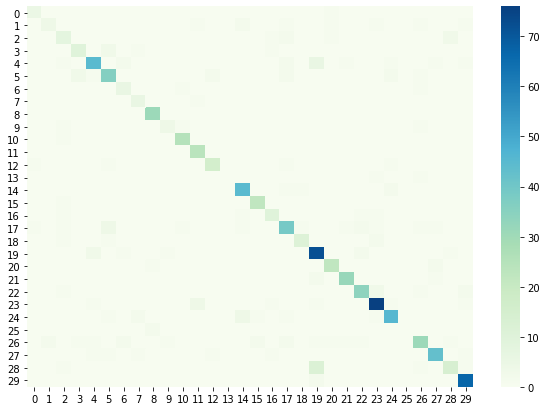

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import collections

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

num_correct = 0
num_total = 0

for idx in range(0, len(flat_predictions)):
  gold = flat_true_labels[idx]
  prediction = flat_predictions[idx]
  if prediction == gold:
      num_correct += 1
  num_total += 1

print("Accuracy: %i / %i = %f" % (num_correct, num_total, float(num_correct) / num_total))
cm = confusion_matrix(flat_true_labels, flat_predictions, labels=list(range(30)))
with np.errstate(divide='ignore', invalid='ignore'):
  recall = np.nan_to_num(np.diag(cm) / np.sum(cm, axis = 1))
  recall = np.mean(recall)
  precision = np.nan_to_num(np.diag(cm) / np.sum(cm, axis = 0))
  precision = np.mean(precision)
  f1 = 2 * precision * recall / (precision + recall)

  print("Precision: %f, Recall: %f, F1: %f" % (precision, recall, f1))
  # c = collections.Counter(flat_predictions)
  # d = collections.Counter(flat_true_labels)
  # for i in range(38):
  #   print('%s : %d' % (i, c[i]))
  #   print('%s : %d' % (i, d[i]))

  df_cm = pd.DataFrame(cm, index = range(cm.shape[0]),
                  columns = range(cm.shape[1]))
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=False, cmap="GnBu")
  plt.show()